**Document Classification using Transformer BERT**

**transformers**: For BERT/DistilBERT models and tokenizers
- **datasets**: load datasets like LexGLUE 
- **accelerate**: makes heavy Transformer training faster, memory-efficient
- **scikit-learn**: For evaluation metrics like accuracy, F1-score, and confusion matrix

In [2]:
!pip install transformers datasets accelerate scikit-learn





-  use Hugging Face `datasets` library to load the LexGLUE ECtHR dataset.
- Print **dataset features**, sizes of train/validation/test splits.
- Extract **category labels** and show **Index to Category mapping**.
- Display a **sample document** with its label(s) . 


In [3]:
from datasets import load_dataset

# Load  LexGLUE ECtHR dataset
dataset = load_dataset("lex_glue", "ecthr_a")

print("Features:", dataset["train"].features)

print("Train size:", len(dataset['train']))
print("Validation size:", len(dataset['validation']))
print("Test size:", len(dataset['test']))

# Extract category labels
labels = dataset['train'].features['labels'].feature.names
print("Number of categories:", len(labels))
print("Categories:", labels)

# mapping from label index to category name
print("\nIndex → Category mapping:")
for idx, name in enumerate(labels):
    print(f"{idx}: {name}")

#  one example
example = dataset['train'][0]
print("\nExample document:")
print("Text snippet:", example['text'][0][:300], "...")
print("Labels:", [labels[i] for i in example['labels']])


README.md: 0.00B [00:00, ?B/s]

ecthr_a/train-00000-of-00001.parquet:   0%|          | 0.00/42.4M [00:00<?, ?B/s]

ecthr_a/test-00000-of-00001.parquet:   0%|          | 0.00/5.68M [00:00<?, ?B/s]

ecthr_a/validation-00000-of-00001.parque(…):   0%|          | 0.00/5.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Features: {'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'labels': Sequence(feature=ClassLabel(names=['2', '3', '5', '6', '8', '9', '10', '11', '14', 'P1-1'], id=None), length=-1, id=None)}
Train size: 9000
Validation size: 1000
Test size: 1000
Number of categories: 10
Categories: ['2', '3', '5', '6', '8', '9', '10', '11', '14', 'P1-1']

Index → Category mapping:
0: 2
1: 3
2: 5
3: 6
4: 8
5: 9
6: 10
7: 11
8: 14
9: P1-1

Example document:
Text snippet: 11.  At the beginning of the events relevant to the application, K. had a daughter, P., and a son, M., born in 1986 and 1988 respectively. P.’s father is X and M.’s father is V. From March to May 1989 K. was voluntarily hospitalised for about three months, having been diagnosed as suffering from sch ...
Labels: ['8']




- train_labels is a list of lists, where each inner list contains one or more labels per document.
- Some documents may have no labels ([]) or multiple labels ([6, 3]).
- train_labels_flat takes only the first label from each document with at least one label.
- Counter is used to compute the frequency of each class.
- The output shows class imbalance, which may need handling during model training.



In [4]:
from collections import Counter

# Extract and inspect training labels
train_labels = dataset['train']['labels']
print(f"Labels type: {type(train_labels)}, Total samples: {len(train_labels)}")
print("First 10 label entries:", train_labels[:10])

# Flatten labels convert to single-label by taking first label 
train_labels_flat = [lbl[0] for lbl in train_labels if len(lbl) > 0]

# Count class frequencies (for imbalance handling)
label_counts = Counter(train_labels_flat)
print("\nClass distribution:", label_counts)


Labels type: <class 'list'>, Total samples: 9000
First 10 label entries: [[4], [], [3], [6], [], [6, 3], [3], [0, 2], [3], [1, 4]]

Class distribution: Counter({3: 4265, 1: 1085, 2: 878, 0: 499, 4: 419, 9: 382, 6: 291, 8: 136, 7: 107, 5: 24})


**Tokenization**



- AutoTokenizer from Hugging Face Transformers is used for BERT.
- Combines text list into a single string for each document.
- Tokenizes text without truncation or padding.
- Returns input_ids, attention_mask, and labels.
- map() applies tokenization to each sample.
- Remove original text column to save memory.
- Tokenized sample keys: input_ids, attention_mask, labels



In [5]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def tokenize_full_text(example):
    full_text = " ".join(example["text"]) #Combines the text list into one string
    tokenized = tokenizer(
        full_text,
        truncation=False,  
        padding=False,
        return_attention_mask=True
    )
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": example["labels"]  
    }

# Tokenize dataset
tokenized_dataset = dataset.map(tokenize_full_text, batched=False)

# Remove the original text column 
tokenized_dataset = tokenized_dataset.remove_columns(["text"])

print(tokenized_dataset["train"][0].keys())


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (8507 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

dict_keys(['labels', 'input_ids', 'attention_mask'])


assigns a doc_id to each document using its index idx.

In [6]:

def add_doc_id(example, idx):
    return {"doc_id": idx}

# Apply to the tokenized dataset
tokenized_dataset = tokenized_dataset.map(add_doc_id, with_indices=True)


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

**chunking with overlap**
 


* Split long tokenized documents into fixed-size chunks with overlap for BERT
* Each chunk contains input\_ids, attention\_mask, original labels, doc\_id, and a chunk index
* Last chunk is padded if shorter than the chunk size
* Apply chunking to the entire dataset using dataset.map
* Keep only necessary columns to save memory
* Break long documents into manageable pieces for training


In [8]:
def chunk_with_overlap_batch(batch, chunk_size=512, overlap=50):
    all_input_ids, all_attention_masks, all_labels = [], [], []
    all_doc_ids, all_chunk_idx = [], []

    for input_ids, attention_mask, labels, doc_id in zip(
        batch["input_ids"], batch["attention_mask"], batch["labels"], batch["doc_id"]
    ):
        start, cidx = 0, 0  # start point for slicing , chunk number 
        while start < len(input_ids):
            end = start + chunk_size
            chunk_ids = input_ids[start:end]
            chunk_mask = attention_mask[start:end]

            if len(chunk_ids) < chunk_size:   # Pad last chunk if it is shorter than chunk_size

                pad = chunk_size - len(chunk_ids)
                chunk_ids += [tokenizer.pad_token_id] * pad
                chunk_mask += [0] * pad
                
           
            all_input_ids.append(chunk_ids)
            all_attention_masks.append(chunk_mask)
            all_labels.append(labels)
            all_doc_ids.append(doc_id)
            all_chunk_idx.append(cidx) #chunk number for each doc

            cidx += 1
            start += chunk_size - overlap # overlapping chunks 
  
    return {
        "input_ids": all_input_ids,
        "attention_mask": all_attention_masks,
        "labels": all_labels,  
        "doc_id": all_doc_ids,
        "chunk_idx": all_chunk_idx,
    }


cols_to_keep = ["input_ids", "attention_mask", "labels", "doc_id"]
cols_to_remove = [c for c in tokenized_dataset["train"].column_names if c not in cols_to_keep]

chunked_dataset = tokenized_dataset.map(
    chunk_with_overlap_batch,
    batched=True,
    remove_columns=cols_to_remove,
)


apply to each chunk , remove if label is empty

In [9]:
def filter_empty_labels(example):
    return len(example["labels"]) > 0

filtered_chunked_dataset = chunked_dataset.filter(filter_empty_labels)


Filter:   0%|          | 0/44129 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5756 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5337 [00:00<?, ? examples/s]

Creates a PyTorch Dataset class named ChunkedLegalDataset to load chunked legal documents with their labels ready for training.

In [10]:
import torch
from collections import Counter
class ChunkedLegalDataset(torch.utils.data.Dataset):
    
    def __init__(self, hf_dataset):
        self.input_ids = hf_dataset["input_ids"]
        self.attention_mask = hf_dataset["attention_mask"]
        self.labels = [lbl[0] if len(lbl) > 0 else 0 for lbl in hf_dataset["labels"]]
        self.doc_ids = hf_dataset["doc_id"]
        
    def __len__(self):
        return len(self.labels)
        
    #eturns a dictionary with tensors input_ids,attention_mask, labels, doc_id
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "doc_id": torch.tensor(self.doc_ids[idx], dtype=torch.long)
        }
#Dataset Creation , Wraps train, validation, and test splits into ChunkedLegalDataset
train_dataset = ChunkedLegalDataset(filtered_chunked_dataset["train"])
val_dataset   = ChunkedLegalDataset(filtered_chunked_dataset["validation"])
test_dataset  = ChunkedLegalDataset(filtered_chunked_dataset["test"])


* define collate_fn to handle a batch of samples from custom PyTorch dataset.

* extract input_ids, attention_mask, labels, doc_id from each item in the batch.

* Pads input_ids and attention_mask to make all sequences the same length .

* Converts labels and doc IDs to tensors.

* Returns a single batch tensor for the model

They are converted to tensors because PyTorch models (BERT, DistilBERT) expect their inputs and labels in tensor format during training .


In [11]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]

    labels_batch = []
    doc_ids_batch = []
    
    for item in batch:
        lbl = item['labels']
        if isinstance(lbl, torch.Tensor):
            lbl = lbl.view(-1)  # Flatten if needed
            if lbl.numel() == 0:
                raise ValueError("Empty label found ") 
            labels_batch.append(lbl[0].item())
        else:
            labels_batch.append(int(lbl))

        doc_ids_batch.append(item['doc_id'].item() if isinstance(item['doc_id'], torch.Tensor) else int(item['doc_id']))

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_batch = torch.tensor(labels_batch, dtype=torch.long)
    doc_ids_batch = torch.tensor(doc_ids_batch, dtype=torch.long)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels_batch,
        'doc_id': doc_ids_batch
    }


 creates DataLoaders that break  dataset into mini-batches of size 8, shuffle only the training data, and use collate_fn to pad sequences and convert everything into tensors. It prepares the data in a modelready format for training, validation, and testing.


In [12]:
from torch.utils.data import DataLoader
batch_size = 8


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [13]:
import torch

# Set device GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


calculates class weights to handle class imbalance using scikit-learn’s compute_class_weight, and then converts these weights into a PyTorch tensor moved to the device . 

In [14]:
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Unique labels
unique_labels = np.unique(train_labels_flat)

# Compute class weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=train_labels_flat
)

# Convert to tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # device = 'cuda' or 'cpu'
print("Class weights:", class_weights_tensor)


Class weights: tensor([ 1.6204,  0.7453,  0.9210,  0.1896,  1.9298, 33.6917,  2.7787,  7.5570,
         5.9456,  2.1168], device='cuda:0')


* attention pooling to combine multiple chunk embeddings into a single document embedding.
* self.attn is a linear layer that assigns a score to each chunk, indicating its importance.
* In forward:
  * chunk_embeddings is a tensor of shape (num_chunks, hidden_size).
  * doc_ids maps each chunk to its original document.
  * Scores are calculated with self.attn and exponentiated to make them positive.
  * For each unique document, its chunks are selected using a mask.
  * Weighted average of chunk embeddings is computed using the scores.
  * pooled_embeddings is stacked into (num_docs, hidden_size )for model input.

This allows BERT to handle long documents split into chunks while emphasizing important chunks . 


In [15]:
import torch
import torch.nn as nn

class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1) # each chunk gets a score , higher = important 

    def forward(self, chunk_embeddings, doc_ids):
        """
        chunk_embeddings: num_chunks, hidden_size
        doc_ids: tensor of doc_ids corresponding to each chunk
        Returns:
            pooled_embeddings: [num_docs, hidden_size]
            unique_docs: tensor of unique doc_ids
        """
        scores = self.attn(chunk_embeddings)  # [num_chunks, 1] 
        scores = torch.exp(scores)           # calculate score for each chunk 

        unique_docs = torch.unique(doc_ids)
        pooled_embeddings = []
        for doc in unique_docs:      #Pick its chunks using a mask.Multiply by its score.Take the weighted average
            mask = (doc_ids == doc)  #boolean tensor filter chunks that belong to the current document.
            doc_chunks = chunk_embeddings[mask]
            doc_scores = scores[mask]
            weighted_sum = (doc_chunks * doc_scores).sum(dim=0) / doc_scores.sum()
            pooled_embeddings.append(weighted_sum)

        pooled_embeddings = torch.stack(pooled_embeddings) #Stack all documents' embeddings together
        return pooled_embeddings, unique_docs


* The device is set to GPU if available, else CPU
* BertModel.from\_pretrained(bert-base-uncased) loads the base BERT model for embeddings
* hidden\_size = bert.config.hidden\_size gets the dimensionality of BERT’s output embeddings
* attn\_pool = AttentionPooling(hidden\_size) creates the custom attention pooling layer to combine chunk embeddings into document-level embeddings
* num\_classes counts the number of document categories from the dataset
* classifier is a small neural network with dropout and a linear layer to predict the document’s class from the pooled embedding



In [16]:
from transformers import BertModel, BertConfig
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Base BERT model
bert = BertModel.from_pretrained("bert-base-uncased").to(device) 
hidden_size = bert.config.hidden_size #gets the size of BERT’s hidden layer

# Attention pooling layer
attn_pool = AttentionPooling(hidden_size).to(device) #creates the custom pooling layer

# Classifier for document level prediction
num_classes = len(dataset['train'].features['labels'].feature.names)
#counts how many categories the documents can belong to.
classifier = nn.Sequential(
    nn.Dropout(p=0.1),   # adds  dropout to prevent overfitting
    nn.Linear(hidden_size, num_classes)
).to(device)
#creates a final layer that predicts classes for each document.


2025-08-26 09:18:15.148464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756199895.500639      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756199895.607623      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

 used for mixed precision training

It scales the loss value before backpropagation to prevent gradients from becoming too small underflow when using lower precision
After backpropagation, it scales the gradients back down to the original scale.

In [17]:
from torch.amp import GradScaler, autocast
scaler = GradScaler() 


In [18]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torch.cuda.amp import GradScaler, autocast
from transformers import get_linear_schedule_with_warmup
import os

# Optimizer
optimizer = torch.optim.AdamW(
    list(bert.parameters()) + list(attn_pool.parameters()) + list(classifier.parameters()),
    lr=1e-5
)

# Loss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


# Mixed precision scaler
scaler = GradScaler()  

# Training hyperparameters

epochs = 5
accumulation_steps = 4

# Scheduler
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# Save directory
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)
best_val_f1 = 0  # for saving best model

# Training loop

for epoch in range(epochs):
    bert.train()
    attn_pool.train()
    classifier.train()
    
    train_preds, train_labels = [], []
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    optimizer.zero_grad()

    for step, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        doc_ids = batch['doc_id'].to(device)

        with autocast():
            outputs = bert(input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            pooled_embeddings, unique_docs = attn_pool(cls_embeddings, doc_ids)
            doc_labels = torch.stack([labels[doc_ids == doc][0] for doc in unique_docs])

            logits = classifier(pooled_embeddings)
            loss = criterion(logits, doc_labels) / accumulation_steps

        scaler.scale(loss).backward()
        train_loss += (loss.item() * accumulation_steps)

        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().tolist())
        train_labels.extend(doc_labels.cpu().tolist())
        loop.set_postfix(loss=loss.item() * accumulation_steps)

    # Training metrics
    train_loss /= len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    
    print(f"Epoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")

    
    # Validation
    
    bert.eval()
    attn_pool.eval()
    classifier.eval()
    
    val_preds, val_labels = [], []
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            doc_ids = batch['doc_id'].to(device)

            outputs = bert(input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            pooled_embeddings, unique_docs = attn_pool(cls_embeddings, doc_ids)
            doc_labels = torch.stack([labels[doc_ids == doc][0] for doc in unique_docs])

            logits = classifier(pooled_embeddings)
            loss = criterion(logits, doc_labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(doc_labels.cpu().tolist())

    # Validation metrics
    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    print(f"Validation — Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

   
    # Save best model based on validation F1
   
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_path = os.path.join(save_dir, f"best_model_epoch{epoch+1}.pth")
        torch.save({
            'bert_state_dict': bert.state_dict(),
            'attn_pool_state_dict': attn_pool.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, save_path)
        print(f"Best model saved at: {save_path}")


/tmp/ipykernel_36/1303733493.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 Training:   0%|          | 0/4772 [00:00<?, ?it/s]/tmp/ipykernel_36/1303733493.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Training: 100%|██████████| 4772/4772 [16:57<00:00,  4.69it/s, loss=1.66] 


Epoch 1 — Train Loss: 1.6351, Train Acc: 0.4028, Train F1: 0.3908
Validation — Loss: 0.9867, Acc: 0.6677, F1: 0.6631
Best model saved at: /kaggle/working/best_model_epoch1.pth


Epoch 2 Training:   0%|          | 0/4772 [00:00<?, ?it/s]/tmp/ipykernel_36/1303733493.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 Training: 100%|██████████| 4772/4772 [16:54<00:00,  4.70it/s, loss=0.22]  


Epoch 2 — Train Loss: 0.7907, Train Acc: 0.6860, Train F1: 0.6906
Validation — Loss: 0.8545, Acc: 0.7124, F1: 0.7183
Best model saved at: /kaggle/working/best_model_epoch2.pth


Epoch 3 Training:   0%|          | 0/4772 [00:00<?, ?it/s]/tmp/ipykernel_36/1303733493.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 Training: 100%|██████████| 4772/4772 [16:54<00:00,  4.71it/s, loss=0.531] 


Epoch 3 — Train Loss: 0.5396, Train Acc: 0.7517, Train F1: 0.7535
Validation — Loss: 0.7823, Acc: 0.7311, F1: 0.7291
Best model saved at: /kaggle/working/best_model_epoch3.pth


Epoch 4 Training:   0%|          | 0/4772 [00:00<?, ?it/s]/tmp/ipykernel_36/1303733493.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 Training: 100%|██████████| 4772/4772 [16:53<00:00,  4.71it/s, loss=0.126] 


Epoch 4 — Train Loss: 0.3833, Train Acc: 0.8025, Train F1: 0.8029
Validation — Loss: 0.7938, Acc: 0.7262, F1: 0.7254


Epoch 5 Training:   0%|          | 0/4772 [00:00<?, ?it/s]/tmp/ipykernel_36/1303733493.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 Training: 100%|██████████| 4772/4772 [16:53<00:00,  4.71it/s, loss=0.0245] 


Epoch 5 — Train Loss: 0.2776, Train Acc: 0.8381, Train F1: 0.8379
Validation — Loss: 0.8135, Acc: 0.7506, F1: 0.7509
Best model saved at: /kaggle/working/best_model_epoch5.pth


Observation of training:

Training loss steadily decreases each epoch.

Accuracy and F1-score improve consistently.

The model is clearly learning and fitting the training data well.

Observation of validation :
Validation accuracy and F1-score steadily improve, peaking at 0.7509 F1 in epoch 5.

Validation loss slightly fluctuates around epoch 4-5, but metrics indicate the model generalizes reasonably.

No severe overfitting is observed

evaluation 


Test Accuracy: 0.7041, Test F1: 0.7060

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.83       121
           1       0.63      0.82      0.72       249
           2       0.59      0.70      0.64       132
           3       0.87      0.59      0.71       343
           4       0.83      0.71      0.76       144
           5       0.12      0.14      0.13         7
           6       0.79      0.59      0.68       118
           7       0.57      0.68      0.62        57
           8       0.33      0.57      0.41        23
           9       0.69      0.75      0.72       107

    accuracy                           0.70      1301
   macro avg       0.62      0.65      0.62      1301
weighted avg       0.73      0.70      0.71      1301



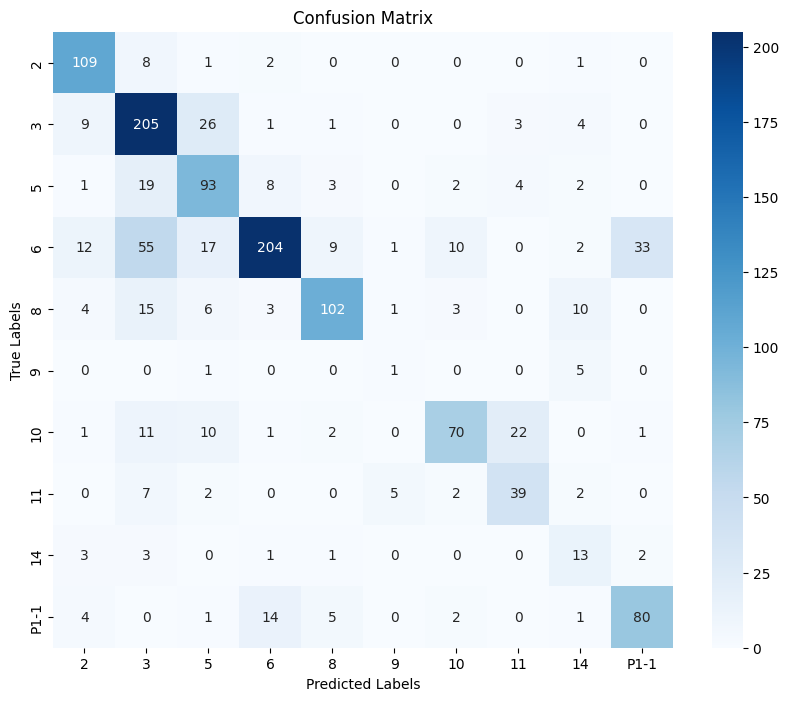

In [24]:

bert.eval()
attn_pool.eval()
classifier.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader: 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        doc_ids = batch['doc_id'].to(device)
        
        # Forward pass through BERT
        outputs = bert(input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]

        # attention pooling
        pooled_embeddings, unique_docs = attn_pool(cls_embeddings, doc_ids)

        # Extract documentlevel labels
        doc_labels = []
        for doc in unique_docs:
            mask = (doc_ids == doc)
            doc_labels.append(labels[mask][0])
        doc_labels = torch.stack(doc_labels)

        # Classifier predictions
        logits = classifier(pooled_embeddings)
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().tolist())
        test_labels.extend(doc_labels.cpu().tolist())

# Calculate metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}\n")
print("Classification Report:\n", classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset['train'].features['labels'].feature.names,
            yticklabels=dataset['train'].features['labels'].feature.names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


 Observations
- The model performs well on classes with more data ( class 0, 1, 3, 4).  
- Performance is low for very small classes (class 5, 8) due to limited examples.  
- Weighted averages indicate the model is moderately reliable overall

Class 0: 499 samples
Class 1: 1085 samples
Class 2: 878 samples
Class 3: 4265 samples
Class 4: 419 samples
Class 5: 24 samples
Class 6: 291 samples
Class 7: 107 samples
Class 8: 136 samples
Class 9: 382 samples


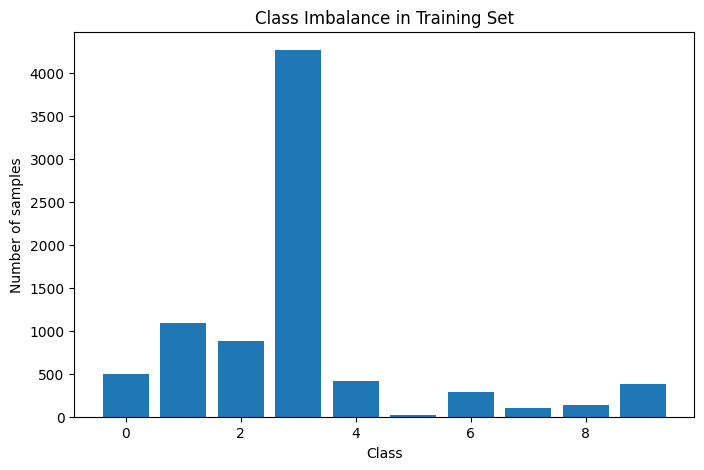

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Number of classes
num_classes = len(dataset['train'].features['labels'].feature.names)

# Count frequency of each class in your labels
class_counts = Counter(train_labels_flat)

# Make sure all classes are included
all_counts = [class_counts.get(i, 0) for i in range(num_classes)]

# Print
for i, count in enumerate(all_counts):
    print(f"Class {i}: {count} samples")

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(num_classes), all_counts)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Imbalance in Training Set")
plt.show()


In [29]:
from datasets import load_dataset

# Example: loading your dataset (replace with your actual dataset)
# dataset = load_dataset("your_dataset_path_or_name")
# Here we assume dataset["train"] exists
label_names = dataset["train"].features["labels"].feature.names

# Print index → class name mapping
for idx, name in enumerate(label_names):
    print(f"Index {idx} → '{name}'")


Index 0 → '2'
Index 1 → '3'
Index 2 → '5'
Index 3 → '6'
Index 4 → '8'
Index 5 → '9'
Index 6 → '10'
Index 7 → '11'
Index 8 → '14'
Index 9 → 'P1-1'


prediction

## Load Model for Prediction

- Load the saved checkpoint containing BERT, attention pooling, and classifier weights.  
- Load the weights into each model component.  
- Set all models to **evaluation mode** and move them to device (CPU/GPU).  
- Model is now ready for making predictions on new data.


In [45]:
import torch

# Load the saved model checkpoint
checkpoint = torch.load("/kaggle/working/bert_modified_epoch5.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")

bert.load_state_dict(checkpoint["bert_state_dict"])
attn_pool.load_state_dict(checkpoint["attn_pool_state_dict"])
classifier.load_state_dict(checkpoint["classifier_state_dict"])

bert.eval()
attn_pool.eval()
classifier.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
bert.to(device)
attn_pool.to(device)
classifier.to(device)

print("Model loaded")


Model loaded


test input 

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict(text):
    # Preprocess input
    encoded = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        pooled, _ = attn_pool(outputs, torch.tensor([0], device=device))
        logits = classifier(pooled)
        probs = torch.softmax(logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

    return pred_class, probs.cpu().numpy()

# Example usage
user_input = "The applicant alleged that his detention without trial for over three years violated his right to liberty and security. further claimed that he had no effective legal remedy to challenge the detention during this period.The government argued that the detention was necessary to prevent disorder during a state of emergency and that the courts had sufficient oversight"
pred, prob = predict(user_input)

print(f"Predicted class: {pred}")
print(f"Probabilities: {prob}")


In [19]:
from transformers import AutoTokenizer

# Load tokenizer 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict(text):
    # Preprocess input
    encoded = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        pooled, _ = attn_pool(outputs, torch.tensor([0], device=device)) 
        logits = classifier(pooled)
        probs = torch.softmax(logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

    return pred_class, probs.cpu().numpy()


user_input = "the applicant is a journalist for dn. no, a norwegian internet - based version of the newspaper dagens næringsliv ( “ dn ” ), published by the company dn nye medier as. 6. on 23 june 2010 mr x was indicted for market manipulation and insider trading under the 1997 act on the trade of financial assets ( verdipapirhandelloven ). he was accused of having requested mr y, an attorney, to draft a letter concerning the norwegian oil company ( “ dno ” ), a limited liability company quoted on the stock exchange. the letter, addressed to a trustee company representing the interests of bond holders in dno ( “ the bond trustee company ” ), gave the impression that it had been written on behalf of a number of bond holders who were seriously concerned about the company ’ s liquidity, finances and future. in fact, it had been written only on mr x ’ s behalf. he had owned only one bond, which he had acquired the same day as he had asked attorney y to draft the letter. 7. mr x had sent a copy of the above - mentioned letter by fax to the applicant on friday 24 august 2007, and in this connection he had a telephone conversation with her. the following day, on saturday 25 august 2007, the applicant wrote an article entitled “ fears of dno collapse ” ( “ frykter at dno rakner ” ), in which she expressed strong concerns about the content of attorney y ’ s letter, a central feature in the article. 8. the price of dno stock fell by 4. 1 % on monday 27 august 2007, the first trading day after the content of the letter had become known in the press. on the same day, a new article on the topic was published in dn. other media also reported on the first article, including an online newspaper ( hegnar online ) which on 28 august 2007 reported that an analyst had stated that he would not be surprised if the letter had been sent by a person with a short - position or who wanted cheap stocks. the oslo stock exchange ( oslo børs ) suspected market manipulation and, having looked into the matter, forwarded the case to the financial supervisory authority ( kredittilsynet ) with suspicions that mr x had infringed the act on the trade of financial assets. during subsequent questioning by the financial supervisory authority, mr x confirmed that he had initiated the letter and been the source of the article in"
pred, prob = predict(user_input)

print(f"Predicted class: {pred}")
print(f"Probabilities: {prob}")


Predicted class: 6
Probabilities: [[1.0710023e-03 9.8609901e-04 1.9824989e-03 6.3547413e-03 1.0370740e-02
  3.9260197e-04 9.7711790e-01 6.7617005e-04 2.5989368e-04 7.8840950e-04]]


In [ ]:
user_input = "final on an unspecified date. 17. on 17 december 2010, upon the second applicant ’ s request to that effect, the nis municipal court ordered the enforcement of the said settlement and further ordered the debtor company to pay the second applicant the enforcement costs. 18. on 5 september 2008 the nis municipal court ordered the debtor company to pay the second applicant specified amounts on account of salary arrears and social insurance contributions, plus the costs of the civil proceedings. this judgment became final by 23 december 2008. 19. on 28 december 2010, upon the second applicant ’ s request to that effect, the nis municipal court ordered the enforcement of the said judgment and further ordered the debtor company to pay the second applicant the enforcement costs." 


In [44]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict(text):
    # Preprocess input
    encoded = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        pooled, _ = attn_pool(outputs, torch.tensor([0], device=device))  
        logits = classifier(pooled)
        probs = torch.softmax(logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

    return pred_class, probs.cpu().numpy()

# Example usage
user_input = "final on an unspecified date. 17. on 17 december 2010, upon the second applicant ’ s request to that effect, the nis municipal court ordered the enforcement of the said settlement and further ordered the debtor company to pay the second applicant the enforcement costs. 18. on 5 september 2008 the nis municipal court ordered the debtor company to pay the second applicant specified amounts on account of salary arrears and social insurance contributions, plus the costs of the civil proceedings. this judgment became final by 23 december 2008. 19. on 28 december 2010, upon the second applicant ’ s request to that effect, the nis municipal court ordered the enforcement of the said judgment and further ordered the debtor company to pay the second applicant the enforcement costs." 
pred, prob = predict(user_input)

print(f"Predicted class: {pred}")
print(f"Probabilities: {prob}")


Predicted class: 3
Probabilities: [[2.4788345e-03 5.1862285e-03 3.0812074e-03 9.3993795e-01 9.7586447e-04
  8.1714522e-04 1.9752365e-03 1.1106398e-03 2.3563470e-04 4.4201277e-02]]


to get an example 

In [43]:
# Pick an index
index = 150


example = test_dataset[index]

# Print the ground truth label
print("Label:", example['labels'].item())

# Decode the tokens back to text (optional, for readability)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
print("Text:", text)


Label: 3
Text: final on an unspecified date. 17. on 17 december 2010, upon the second applicant ’ s request to that effect, the nis municipal court ordered the enforcement of the said settlement and further ordered the debtor company to pay the second applicant the enforcement costs. 18. on 5 september 2008 the nis municipal court ordered the debtor company to pay the second applicant specified amounts on account of salary arrears and social insurance contributions, plus the costs of the civil proceedings. this judgment became final by 23 december 2008. 19. on 28 december 2010, upon the second applicant ’ s request to that effect, the nis municipal court ordered the enforcement of the said judgment and further ordered the debtor company to pay the second applicant the enforcement costs. 20. on 30 june 2007 and 15 october 2007 respectively, the republic agency for peaceful settlement of labour disputes ordered the debtor company to pay the second applicant specified amounts on account o

K-Fold


* Load PyTorch libraries for building and training neural networks
* Load Subset and DataLoader to handle dataset batching
* Load KFold from sklearn for cross-validation
* Load metrics accuracy\_score and f1\_score to evaluate model performance
* Load GradScaler and autocast for mixed precision training for faster computation and lower memory usage
* Load BERT model and learning rate scheduler from transformers
* Load os for file and directory handling



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from torch.cuda.amp import GradScaler, autocast
from transformers import BertModel, get_linear_schedule_with_warmup
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


2025-08-25 18:14:17.479668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756145657.850049      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756145657.959905      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


* Use the chunked training dataset created earlier for K-Fold evaluation

* Wrap the chunked dataset into a PyTorch Dataset object - ChunkedLegalDataset

* Each fold will get a portion of the data for training and another for validation

* Set up K-Fold with 5 splits, shuffling the data and fixing a random seed for reproducibility

In [22]:
#  chunked dataset
full_dataset = ChunkedLegalDataset(filtered_chunked_dataset['train'])
print("Number of samples in full dataset:", len(full_dataset))

# K-Fold setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Hyperparameters
epochs = 3           
batch_size = 8
accumulation_steps = 4
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

# Mixed precision
scaler = GradScaler()


Number of samples in full dataset: 38175


/tmp/ipykernel_36/3765128555.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


* defines a function to create a fresh model for each fold of K-Fold cross-validation.
* Inside the function:
* bert loads the pre-trained BERT model.
* AttentionPooling is defined to combine embeddings of document chunks into a single document representation using attention scores.

      Each chunk gets a score.
      Weighted sum of chunk embeddings gives the document embedding.

* classifier is a simple linear layer with dropout to predict the document class.

* The function returns a new BERT, attention pooling, and classifier for each fold.

* Using a fresh model ensures that each fold is trained independently and results are not biased.

* Each fold will get a portion of the data for training and another for validation

In [23]:
# Function to create  model for each fold
def create_model(num_classes):
    bert = BertModel.from_pretrained("bert-base-uncased").to(device)
    hidden_size = bert.config.hidden_size

    # Attention Pooling
    class AttentionPooling(nn.Module):
        def __init__(self, hidden_size):
            super().__init__()
            self.attn = nn.Linear(hidden_size, 1)
        def forward(self, chunk_embeddings, doc_ids):
            scores = self.attn(chunk_embeddings)
            scores = torch.exp(scores)
            unique_docs = torch.unique(doc_ids)
            pooled_embeddings = []
            for doc in unique_docs:
                mask = (doc_ids == doc)
                doc_chunks = chunk_embeddings[mask]
                doc_scores = scores[mask]
                weighted_sum = (doc_chunks * doc_scores).sum(dim=0) / doc_scores.sum()
                pooled_embeddings.append(weighted_sum)
            pooled_embeddings = torch.stack(pooled_embeddings)
            return pooled_embeddings, unique_docs

    attn_pool = AttentionPooling(hidden_size).to(device)
    
    classifier = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(hidden_size, num_classes)
    ).to(device)
    
    return bert, attn_pool, classifier


In [26]:
from tqdm import tqdm
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n=== Fold {fold+1}/{n_splits} ===")
    
    # Subsets and DataLoaders
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # Create fresh model
    num_classes = len(filtered_chunked_dataset['train'].features['labels'].feature.names)
    #get number of output classes
    bert, attn_pool, classifier = create_model(num_classes)
    
    optimizer = torch.optim.AdamW(
        list(bert.parameters()) + list(attn_pool.parameters()) + list(classifier.parameters()),
        lr=1e-5
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    # Training
    for epoch in range(epochs):
        bert.train(); attn_pool.train(); classifier.train() #set model to training mode 
        all_preds, all_labels = [], []
        loop = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1} Training")
        optimizer.zero_grad() # reset gradient beforestarting 
        
        for step, batch in enumerate(loop): #loop through each batch 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            doc_ids = batch['doc_id'].to(device)
            
            with autocast(): #use mixed precision 
                outputs = bert(input_ids, attention_mask=attention_mask) # get bert embedding
                cls_embeddings = outputs.last_hidden_state[:, 0, :] #take CLS token embedding
                pooled_embeddings, unique_docs = attn_pool(cls_embeddings, doc_ids) #pool chunk embeddings per document
                doc_labels = torch.stack([labels[doc_ids == doc][0] for doc in unique_docs])#get one label per document
                
                logits = classifier(pooled_embeddings) #pass pooled embeddings through classifier
                loss = criterion(logits, doc_labels) / accumulation_steps
            
            scaler.scale(loss).backward()
            
            if (step + 1) % accumulation_steps == 0:  #after accumulation , update optimizer 
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            preds = torch.argmax(logits, dim=1)   #track predictions               
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(doc_labels.cpu().tolist())
            loop.set_postfix(loss=loss.item() * accumulation_steps)
        
        train_acc = accuracy_score(all_labels, all_preds)  #Compute metrics at epoch end
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Epoch {epoch+1} — Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
    
    # Validation
    bert.eval(); attn_pool.eval(); classifier.eval() #set models to evaluation mode
    val_preds, val_labels = [], []
    
    val_loop = tqdm(val_loader, desc=f"Fold {fold+1} Validation")
    with torch.no_grad():
        for batch in val_loop: 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            doc_ids = batch['doc_id'].to(device)

            #get embeddings → pool → classify → store predictions and labels
            outputs = bert(input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            pooled_embeddings, unique_docs = attn_pool(cls_embeddings, doc_ids)
            doc_labels = torch.stack([labels[doc_ids == doc][0] for doc in unique_docs])
            
            logits = classifier(pooled_embeddings)
            preds = torch.argmax(logits, dim=1)
            
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(doc_labels.cpu().tolist())
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    print(f"Validation — Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    
    fold_results.append((val_acc, val_f1))



=== Fold 1/5 ===


Fold 1 Epoch 1 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 1 Epoch 1 Training: 100%|██████████| 3818/3818 [13:51<00:00,  4.59it/s, loss=2.39] 


Epoch 1 — Train Acc: 0.6050, Train F1: 0.6050


Fold 1 Epoch 2 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 1 Epoch 2 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.214] 


Epoch 2 — Train Acc: 0.7322, Train F1: 0.7349


Fold 1 Epoch 3 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 1 Epoch 3 Training: 100%|██████████| 3818/3818 [13:46<00:00,  4.62it/s, loss=1.24]  


Epoch 3 — Train Acc: 0.7810, Train F1: 0.7817


Fold 1 Validation: 100%|██████████| 955/955 [03:51<00:00,  4.13it/s]


Validation — Acc: 0.7981, F1: 0.8008

=== Fold 2/5 ===


Fold 2 Epoch 1 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 2 Epoch 1 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.229] 


Epoch 1 — Train Acc: 0.6249, Train F1: 0.6259


Fold 2 Epoch 2 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 2 Epoch 2 Training: 100%|██████████| 3818/3818 [13:47<00:00,  4.61it/s, loss=0.978] 


Epoch 2 — Train Acc: 0.7392, Train F1: 0.7423


Fold 2 Epoch 3 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 2 Epoch 3 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.11]  


Epoch 3 — Train Acc: 0.7921, Train F1: 0.7932


Fold 2 Validation: 100%|██████████| 955/955 [03:50<00:00,  4.14it/s]


Validation — Acc: 0.7814, F1: 0.7859

=== Fold 3/5 ===


Fold 3 Epoch 1 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 3 Epoch 1 Training: 100%|██████████| 3818/3818 [13:49<00:00,  4.60it/s, loss=0.739] 


Epoch 1 — Train Acc: 0.6214, Train F1: 0.6233


Fold 3 Epoch 2 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 3 Epoch 2 Training: 100%|██████████| 3818/3818 [13:49<00:00,  4.60it/s, loss=0.157] 


Epoch 2 — Train Acc: 0.7314, Train F1: 0.7343


Fold 3 Epoch 3 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 3 Epoch 3 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.0622]


Epoch 3 — Train Acc: 0.7840, Train F1: 0.7852


Fold 3 Validation: 100%|██████████| 955/955 [03:50<00:00,  4.14it/s]


Validation — Acc: 0.7508, F1: 0.7577

=== Fold 4/5 ===


Fold 4 Epoch 1 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 4 Epoch 1 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.697] 


Epoch 1 — Train Acc: 0.6117, Train F1: 0.6128


Fold 4 Epoch 2 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 4 Epoch 2 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.407] 


Epoch 2 — Train Acc: 0.7395, Train F1: 0.7420


Fold 4 Epoch 3 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 4 Epoch 3 Training: 100%|██████████| 3818/3818 [13:48<00:00,  4.61it/s, loss=0.912] 


Epoch 3 — Train Acc: 0.7924, Train F1: 0.7929


Fold 4 Validation: 100%|██████████| 955/955 [03:50<00:00,  4.14it/s]


Validation — Acc: 0.7854, F1: 0.7896

=== Fold 5/5 ===


Fold 5 Epoch 1 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 5 Epoch 1 Training: 100%|██████████| 3818/3818 [13:47<00:00,  4.62it/s, loss=0.352] 


Epoch 1 — Train Acc: 0.6184, Train F1: 0.6190


Fold 5 Epoch 2 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 5 Epoch 2 Training: 100%|██████████| 3818/3818 [13:47<00:00,  4.62it/s, loss=1.01]  


Epoch 2 — Train Acc: 0.7326, Train F1: 0.7354


Fold 5 Epoch 3 Training:   0%|          | 0/3818 [00:00<?, ?it/s]/tmp/ipykernel_36/4014774358.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 5 Epoch 3 Training: 100%|██████████| 3818/3818 [13:46<00:00,  4.62it/s, loss=0.0418]


Epoch 3 — Train Acc: 0.7844, Train F1: 0.7855


Fold 5 Validation: 100%|██████████| 955/955 [03:50<00:00,  4.14it/s]

Validation — Acc: 0.7863, F1: 0.7895


Observations:

Consistent improvement over epochs for each fold.

Validation accuracy remained between ~0.75 and 0.80 across folds, showing stable performance.

Training and validation scores are close, meaning the model is not heavily overfitting.

Fold 3 had the lowest validation performance -0.75 F1, while Fold 1 had the highest-0.80 F1.

In [2]:
import torch

# fold results
fold_accuracies = [0.7981, 0.7814, 0.7508, 0.7854, 0.7863]
fold_f1s = [0.8008, 0.7859, 0.7577, 0.7896, 0.7895]

# Mean and standard deviation
mean_acc = sum(fold_accuracies) / len(fold_accuracies)
std_acc = torch.std(torch.tensor(fold_accuracies))

mean_f1 = sum(fold_f1s) / len(fold_f1s)
std_f1 = torch.std(torch.tensor(fold_f1s))

print(f"Mean Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Mean Validation F1: {mean_f1:.4f} ± {std_f1:.4f}")


Mean Validation Accuracy: 0.7804 ± 0.0177
Mean Validation F1: 0.7847 ± 0.0161


 model is performing consistently across different data splits.

The low standard deviation means it's not too dependent on one specific fold.

F1 being close to accuracy suggests balanced predictions across classes , no major class imbalance effects remaining 

REFERENCES 

* https://youtu.be/gJo0uNL-5Qw?si=xWI6xobKgJTahjlW - K Fold Cross Validation
* https://youtu.be/4nNbg4bWDrQ?si=3H97-yxfCDT6jDmS - FineTuning BERT for Multi-Class Classification on custom Dataset
* https://youtu.be/_eSGWNqKeeY?si=n9_GlfyyDTC1s4YJ - BERT Document Classification Tutorial
* https://colab.research.google.com/drive/1CfsGHuNWGGLg7ArPD_WE3sRuzFbDJav8#scrollTo=02NmUilP4Abs  - BERT Document Classification Tutorial Notebook 


